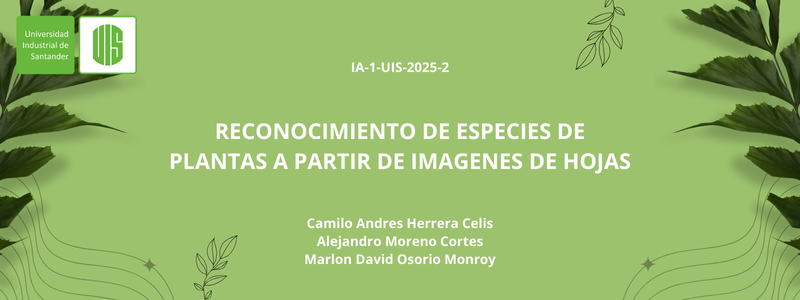

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Modifica las rutas según tu estructura en Drive
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/IA/IA-Proy/Dataset/data/' #Imagenes sin procesar
processed_dir = '/content/drive/MyDrive/Colab Notebooks/IA/IA-Proy/Dataset/procesados/data/' #Imagenes ya procesadas
img_size = (224, 224)
batch_size = 8
epochs = 20

# En caso de tener una imagen distinta a las del dataset para probar (Revisar la extension del archivo para evitar problemas)
test_img = '/content/drive/MyDrive/Colab Notebooks/IA/IA-Proy/Dataset/test/test.png'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocesado de imagenes

# NO CORRER SI YA ESTAN PROCESADAS!!!

In [ ]:
from PIL import Image
import os
from tqdm import tqdm

def preprocesado(paths, used, rot_right=[], rot_left=[], size=(224, 224)):

    # Crear ruta destino
    os.makedirs(processed_dir, exist_ok=True)
    print(f"📁 Carpeta de salida: {processed_dir}")

    # Iterar sobre las carpetas de clase con barra de progreso
    class_folders = used

    for clase in tqdm(class_folders, desc="Procesando carpetas", unit="clase"):
        input_dir = os.path.join(paths, clase)
        output_dir = os.path.join(processed_dir, clase)
        os.makedirs(output_dir, exist_ok=True)

        for file in os.listdir(input_dir):
            if not file.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)

            try:
                with Image.open(input_path) as img:
                    img = img.convert("L") #Comentar en caso de que ya esten en blanco y negro
                    img = img.point(lambda x: 255 if x>0 else 0, "L") #Comentar en caso de que ya esten en blanco y negro
                    img = img.resize(size)

                    if clase in rot_left:
                        img = img.rotate(-90, Image.NEAREST)
                    elif clase in rot_right:
                        img = img.rotate(90, Image.NEAREST)

                    img.save(output_path)
            except Exception as e:
                print(f"⚠️ Error procesando {input_path}: {e}")

    print("✅ Procesamiento completo.")

left = [] # Esto es por si hay alguna clase a la que haya que girar todas sus imagenes en -90 grados
right = [] # Lo mismo pero para girarlas 90 grados

# Esto es en caso de que hayan clases en el dataset que no se quieran tomar, se excluyan de este array
used = ["Árbol 1", "Árbol 2", "Árbol 3", "Árbol 4", "Árbol 5", "Árbol 6"]

img = preprocesado(paths=dataset_dir, used=used, rot_right=right, rot_left=left)

📁 Carpeta de salida: /content/drive/MyDrive/Colab Notebooks/IA/IA-Proy/Dataset/procesados/data/


Procesando carpetas: 100%|██████████| 6/6 [00:16<00:00,  2.75s/clase]

✅ Procesamiento completo.


Cargar el dataset o crearlo si no existe

In [5]:
from PIL import Image
import numpy as np
import pandas as pd
import os
np.random.seed(23)

# Ruta en la que se quiera guardar el csv del dataframe
path_dataframe = "/content/drive/MyDrive/Colab Notebooks/IA/IA-Proy/Dataset/data.csv"

def img_a_dataframe(path):
  data = []
  clases = sorted(os.listdir(path))
  print(f"Hay {len(clases)} clases")

  for clase in clases:
    class_route = os.path.join(path, clase)
    if not os.path.isdir(class_route):
      continue
    for img_file in sorted(os.listdir(class_route)):
      img_route = os.path.join(class_route, img_file)
      try:
        with Image.open(img_route) as img:
          img = img.convert("L") # Si se quiere trabajar con colores, cambiar esto a RGB
          flat_arr = np.array(img).flatten()
          data.append([clase] + flat_arr.tolist())
      except Exception as e:
        print(e)

  columns = ["clase"] + [f"pixel_{i}" for i in range(224*224)]
  df = pd.DataFrame(data, columns=columns)
  return df


if not os.path.exists(path_dataframe):
  print("Procesando imagenes")
  data = img_a_dataframe(processed_dir)
  data.to_csv(path_dataframe, index=False)
  print(data.shape)
else:
  data = pd.read_csv(path_dataframe)
  print(data.shape)




(113, 50177)


Correr si se va a hacer algun test LUEGO DE HABER USADO TODOS LOS METODOS

(1, 50176)


NameError: name 'gnb' is not defined

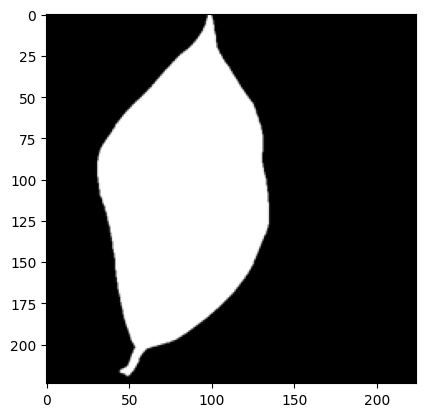

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Asegurarse que la imagen no esta en el dataset
img = Image.open(test_img)
img = img.convert("L") #En caso de tener el dataset en grayscale y la imagen en rgb
img = img.point(lambda x: 255 if x>0 else 0, "L") #Comentar esta y la anterior si se quiere trabajar en rgb
img = img.resize(img_size)
img = np.array(img)
img = img.flatten()
img = img.reshape(1, -1)
img = pd.DataFrame(img)


img = img.astype(float)/255
print(img.shape)
plt.imshow(img.values.reshape(img_size[0], img_size[1]), cmap="gray")

print("Gaussian Naive Bayes: ", gnb.predict(img))
print("DecisionTree: ", tree.predict(img))
print("RandomForest: ", randomForest.predict(img))
print("Support Vector Classifier(Kernel Poly): ", svc.predict(img))

img = img*255 #Para evitar luego el procesar los valores del model.predict
prediction = model.predict(img.reshape([-1, img_size[0], img_size[1], 1]))



---





PRUEBAS




---



Particionar datos de training y testing

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X = data.drop('clase', axis=1)
y = data['clase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, shuffle=True)

X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)



---

PRUEBA CON DECISIONTREE



---




In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
np.random.seed(23)

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

y_pred_dt = tree.predict(X_test)
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

0.6956521739130435
              precision    recall  f1-score   support

    Árbol 1       0.00      0.00      0.00         1
    Árbol 2       1.00      0.67      0.80         3
    Árbol 3       0.57      1.00      0.73         4
    Árbol 4       0.67      0.33      0.44         6
    Árbol 5       0.78      1.00      0.88         7
    Árbol 6       0.50      0.50      0.50         2

    accuracy                           0.70        23
   macro avg       0.59      0.58      0.56        23
weighted avg       0.68      0.70      0.66        23



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




---

Prueba con RandomForest


---



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

randomForest = RandomForestClassifier(n_estimators=100, random_state=0)
randomForest.fit(X_train, y_train)

y_pred_rf = randomForest.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

0.8260869565217391
              precision    recall  f1-score   support

    Árbol 1       1.00      1.00      1.00         1
    Árbol 2       1.00      0.67      0.80         3
    Árbol 3       1.00      0.75      0.86         4
    Árbol 4       1.00      0.83      0.91         6
    Árbol 5       0.78      1.00      0.88         7
    Árbol 6       0.33      0.50      0.40         2

    accuracy                           0.83        23
   macro avg       0.85      0.79      0.81        23
weighted avg       0.87      0.83      0.84        23





---

PRUEBA CON SVR



---



In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

test_kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in test_kernels:
  svc = SVC(kernel=kernel, random_state=0)
  svc.fit(X_train, y_train)
  y_pred_svc = svc.predict(X_test)
  print(kernel)
  print(accuracy_score(y_test, y_pred_svc))

svc = SVC(kernel='poly', random_state=0)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("Kernel: Poly -> ", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))
#

linear
0.782608695652174
poly
0.8260869565217391
rbf
0.7391304347826086
sigmoid
0.391304347826087
Kernel: Poly ->  0.8260869565217391
              precision    recall  f1-score   support

    Árbol 1       1.00      1.00      1.00         1
    Árbol 2       1.00      0.67      0.80         3
    Árbol 3       1.00      0.75      0.86         4
    Árbol 4       0.83      0.83      0.83         6
    Árbol 5       0.78      1.00      0.88         7
    Árbol 6       0.50      0.50      0.50         2

    accuracy                           0.83        23
   macro avg       0.85      0.79      0.81        23
weighted avg       0.85      0.83      0.82        23



---

Prueba con Gaussian Naive Bayes

---

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred_gnb))
print(classification_report(y_test, y_pred_gnb))

0.5652173913043478
              precision    recall  f1-score   support

    Árbol 1       0.00      0.00      0.00         1
    Árbol 2       1.00      1.00      1.00         3
    Árbol 3       0.36      1.00      0.53         4
    Árbol 4       1.00      0.33      0.50         6
    Árbol 5       0.60      0.43      0.50         7
    Árbol 6       1.00      0.50      0.67         2

    accuracy                           0.57        23
   macro avg       0.66      0.54      0.53        23
weighted avg       0.72      0.57      0.56        23



---

Red neuronal Densa

---

In [15]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

tf.random.set_seed(23)

X_train = X_train.reshape([-1, img_size[0], img_size[1], 1])
X_test = X_test.reshape([-1, img_size[0], img_size[1], 1])

le = LabelEncoder()
le.fit(np.concatenate((y_train, y_test), axis=0))

y_train_arr = le.transform(y_train)
y_test_arr = le.transform(y_test)

num_classes = len(le.classes_)

y_train_cat = to_categorical(y_train_arr, num_classes=num_classes)
y_test_cat = to_categorical(y_test_arr, num_classes=num_classes)

model = Sequential([
    tf.keras.layers.Flatten(input_shape=(img_size[0] * img_size[1], 1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_cat))

loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f'Test accuracy: {accuracy}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,929,286 (98.91 MB)

 Trainable params: 25,929,286 (98.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - accuracy: 0.1954 - loss: 4.7631 - val_accuracy: 0.2174 - val_loss: 6.3924
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - accuracy: 0.3401 - loss: 5.1418 - val_accuracy: 0.3478 - val_loss: 3.1442
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 568ms/step - accuracy: 0.2908 - loss: 3.2027 - val_accuracy: 0.4348 - val_loss: 2.1272
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 573ms/step - accuracy: 0.4948 - loss: 2.2460 - val_accuracy: 0.4783 - val_loss: 2.6089
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3827 - loss: 2.2542 - val_accuracy: 0.4783 - val_loss: 1.3970
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 719ms/step - accuracy: 0.5348 - loss: 1.3335 - val_accuracy: 0.3478 - val_loss: 1.4169
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.4874 - loss: 1.4362 - val_accuracy: 0.4783 - val_loss: 1.1475
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.5633 - loss: 1.0597 - val_accuracy: 0

Matriz de confusion

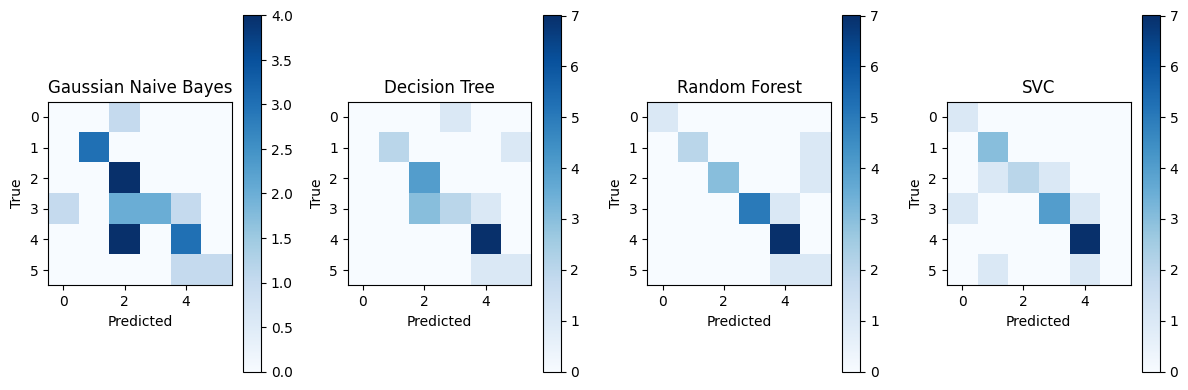

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_nb = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(cm_nb, cmap='Blues')
plt.title('Gaussian Naive Bayes')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 4, 2)
plt.imshow(cm_dt, cmap='Blues')
plt.title('Decision Tree')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 4, 3)
plt.imshow(cm_rf, cmap='Blues')
plt.title('Random Forest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 4, 4)
plt.imshow(cm_svc, cmap='Blues')
plt.title('SVC')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


---

##Modelos no supervisados

---

KMeans

KMeans con PCA y TSNE
clase        Árbol 1  Árbol 2  Árbol 3  Árbol 4  Árbol 5  Árbol 6
Cluster_PCA                                                            
0                   2         0         2         1         0         1
1                  11        20         0         1         0         8
2                   0         0         1         1        21         1
3                   0         0        10         0         0         0
4                   8         1         6        14         1         1
5                   0         0         2         0         0         0
clase         Árbol 1  Árbol 2  Árbol 3  Árbol 4  Árbol 5  Árbol 6
Cluster_TSNE                                                            
0                    0         0        13         0         0         0
1                    5         7         1         0         0         8
2                    1         0         2         1        22         2
3                    1         0     

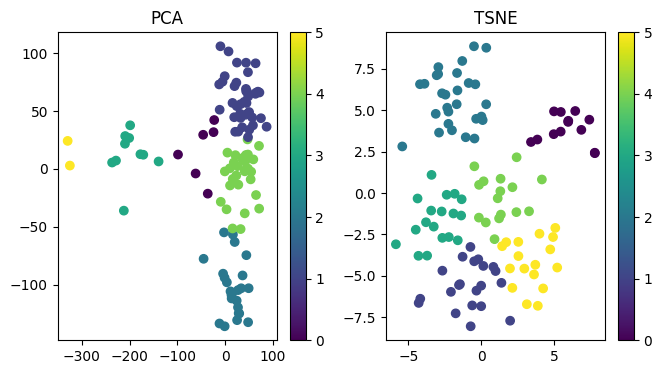

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("KMeans con PCA y TSNE")

dataKmeans = data.copy()
X = dataKmeans.drop('clase', axis=1)

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

kmeansPCA = KMeans(n_clusters=len(np.unique(y)), random_state=23)
kmeansPCA.fit(X_pca)
labelsPCA = kmeansPCA.labels_

kmeansTSNE = KMeans(n_clusters=len(np.unique(y)), random_state=23)
kmeansTSNE.fit(X_tsne)
labelsTSNE = kmeansTSNE.labels_

# Esto es para ver la cantidad de imagenes por clase
dataKmeans['Cluster_PCA'] = labelsPCA
dataKmeans['Cluster_TSNE'] = labelsTSNE
tabla_pca = dataKmeans.groupby(['Cluster_PCA', 'clase']).size().unstack(fill_value=0)
print(tabla_pca)
tabla_tsne = dataKmeans.groupby(['Cluster_TSNE', 'clase']).size().unstack(fill_value=0)
print(tabla_tsne)

# Esto es para visualizacion
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labelsPCA)
plt.title('PCA')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labelsTSNE)
plt.title('TSNE')
plt.colorbar()

---

DBSCAN


DBSCAN con PCA y TSNE
59  Imagenes clasificadas como ruido de  113
Detectadas como ruido
No detectadas como ruido


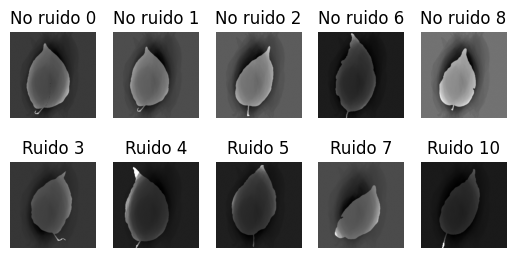

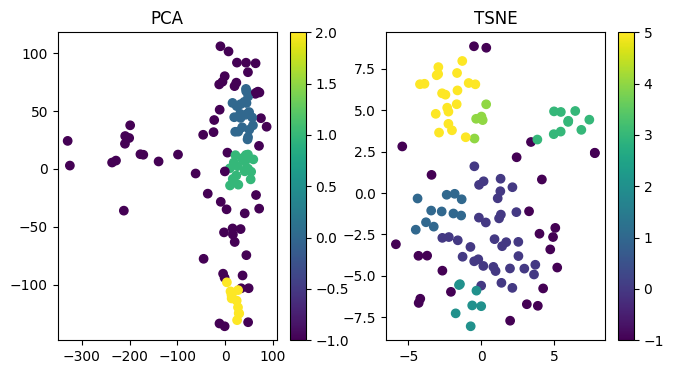

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("DBSCAN con PCA y TSNE")

X = data.drop('clase', axis=1)

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

dbsPCA = DBSCAN(eps=13.2, min_samples=5)
dbsPCA.fit(X_pca)
labelsPCA = dbsPCA.labels_

dbsTSNE = DBSCAN(eps=1.3, min_samples=5)
dbsTSNE.fit(X_tsne)
labelsTSNE = dbsTSNE.labels_

ruido_indices = np.where(labelsPCA == -1)[0]
no_ruido_indices = np.where(labelsPCA != -1)[0]
print(len(ruido_indices), " Imagenes clasificadas como ruido de ", len(X_scaled))

# Graficar algunas imagenes de ruido
muestras = ruido_indices[:5]
X = pd.DataFrame(X_scaled)

print("Detectadas como ruido")
for i, idx in enumerate(muestras):
    img = X.iloc[idx].values.reshape(224, 224)

    plt.subplot(1, len(muestras), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Ruido {idx}")
    plt.axis("off")

print("No detectadas como ruido")
muestras = no_ruido_indices[:5]

for i, idx in enumerate(muestras):
    img = X.iloc[idx].values.reshape(224, 224)

    plt.subplot(3, len(muestras), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"No ruido {idx}")
    plt.axis("off")


# Esto es para visualizacion de clusters y tal
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labelsPCA)
plt.title('PCA')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labelsTSNE)
plt.title('TSNE')
plt.colorbar()

---

Agglomerative

Agglomerative Clustering con PCA y TSNE
clase        Árbol 1  Árbol 2  Árbol 3  Árbol 4  Árbol 5  Árbol 6
Cluster_PCA                                                            
0                   8         1         6        15         2         1
1                  11        19         1         1         0         8
2                   0         0         0         0        20         1
3                   0         0        10         0         0         0
4                   2         1         2         1         0         1
5                   0         0         2         0         0         0
clase         Árbol 1  Árbol 2  Árbol 3  Árbol 4  Árbol 5  Árbol 6
Cluster_TSNE                                                            
0                    1         0         6        15         0         0
1                    1         0         1         1        22         2
2                    1         0        13         1         0         0
3                  

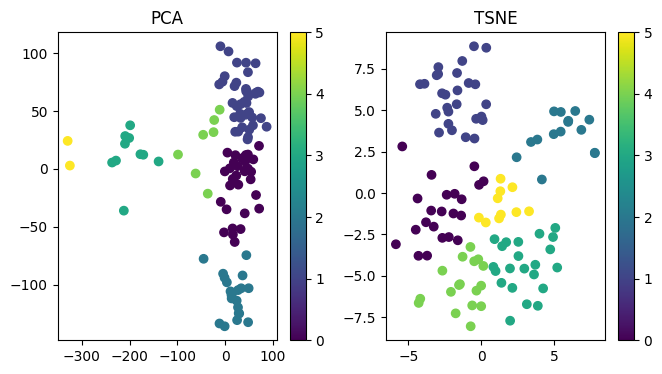

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print("Agglomerative Clustering con PCA y TSNE")

dataAgg = data.copy()
X = dataAgg.drop('clase', axis=1)

X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

aggPCA = AgglomerativeClustering(n_clusters=len(np.unique(y)), linkage='ward')
aggPCA.fit(X_pca)
labelsPCA = aggPCA.labels_

aggTSNE = AgglomerativeClustering(n_clusters=len(np.unique(y)), linkage='ward')
aggTSNE.fit(X_tsne)
labelsTSNE = aggTSNE.labels_

# Esto es para ver la cantidad de imagenes por clase
dataAgg['Cluster_PCA'] = labelsPCA
dataAgg['Cluster_TSNE'] = labelsTSNE
tabla_pca = dataAgg.groupby(['Cluster_PCA', 'clase']).size().unstack(fill_value=0)
print(tabla_pca)
tabla_tsne = dataAgg.groupby(['Cluster_TSNE', 'clase']).size().unstack(fill_value=0)
print(tabla_tsne)

# Esto es para visualizacion
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labelsPCA)
plt.title('PCA')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labelsTSNE)
plt.title('TSNE')
plt.colorbar()